# Model NEATM 余亮亮 修改alpha phi 
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# LS_NEATM
## import & define const

In [1]:
#import
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math as mh 

#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 10
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model_hhq

In [2]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            #print(f"Tss = {T-273}\n")
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    #print('hhq',delta)
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))

    F = F*(lamda)**2/cl*1e29
    #print('hhq2',delta)
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

### Model_jhx

In [3]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,abs(alpha-pi)/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)-1):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

/tmp/ipykernel_349523/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


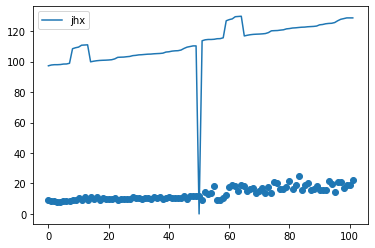

In [4]:
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#print(obsec)
obsdat = np.loadtxt(f'obs_{name}.txt')
#obstime  = np.loadtxt(f'fobs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
#print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
y = obsdat
nn = len(d_N)
nt = np.arange(nn)
plt.scatter(nt,y)
#delta_N,d_N,alpha_N = x
theta = [2.4,1038]
#flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
plt.plot(nt,flux2,label = 'jhx')
plt.legend()


## define LOSS_function

In [5]:
#loss Function
def loss_func(y,yerr,y_cal):
    n = len(y)
    #for i in range(n):
    #    print(y[i],y_cal[i],mh.pow((y[i]-y_cal[i])/1,1))
    return sum(np.power((y-y_cal)/yerr,2))/n


In [6]:
#initial
eta_gss = [0.1,2.8,0.1]
D_gss = [200,500,1]

In [17]:
n_eta = int((eta_gss[1]-eta_gss[0])/eta_gss[2]+1)                     
n_D = int((D_gss[1]-D_gss[0])/D_gss[2]+1)
Ntime = n_eta*n_D         
print(f'It`s need {Ntime} setps',f'eta={n_eta} d={n_D}')

loss = 10e6
nstep = 0
Di = D_gss[0]
for i in tqdm.tqdm(range(n_D)):
    etai = eta_gss[0]
    for j in tqdm.tqdm(range(n_eta), leave=False):
        flux = np.zeros(nn)
        flux = Model_neatm_ohhq(theta=(etai,Di),x=x,lamda=lamdai)
        lossi = loss_func(y,1,flux)
        if lossi<loss :
            loss = lossi
            eta_fit = etai
            D_fit  = Di
            print(f'step {nstep} :loss = {lossi} eta = {eta_fit} D = {D_fit}')
        etai = etai + eta_gss[2]
        #print(etai)
        nstep = nstep + 1
    Di = Di + D_gss[2]


It`s need 8127 setps eta=27 d=301


  0%|          | 0/301 [00:00<?, ?it/s]/tmp/ipykernel_349523/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


step 0 :loss = 2718.830211597701 eta = 0.1 D = 200
step 1 :loss = 951.0979124706057 eta = 0.2 D = 200
step 2 :loss = 449.9424027962669 eta = 0.30000000000000004 D = 200


step 3 :loss = 241.14783592883063 eta = 0.4 D = 200
step 4 :loss = 138.19162190599383 eta = 0.5 D = 200
step 5 :loss = 82.75437094160377 eta = 0.6 D = 200


step 6 :loss = 51.566990986125376 eta = 0.7 D = 200
step 7 :loss = 33.84356410421035 eta = 0.7999999999999999 D = 200
step 8 :loss = 24.046220972970072 eta = 0.8999999999999999 D = 200
step 9 :loss = 19.112638518018382 eta = 0.9999999999999999 D = 200


step 10 :loss = 17.251787215742333 eta = 1.0999999999999999 D = 200


  0%|          | 1/301 [00:01<09:33,  1.91s/it]

step 37 :loss = 17.18886401590599 eta = 1.0999999999999999 D = 201
step 38 :loss = 17.05140590056239 eta = 1.2 D = 201


  1%|          | 2/301 [00:03<09:16,  1.86s/it]

step 65 :loss = 16.77257992032457 eta = 1.2 D = 202


  1%|          | 3/301 [00:05<09:09,  1.84s/it]

step 92 :loss = 16.533715649051068 eta = 1.2 D = 203


  1%|▏         | 4/301 [00:07<09:03,  1.83s/it]

step 119 :loss = 16.335412689906935 eta = 1.2 D = 204


  2%|▏         | 5/301 [00:09<08:59,  1.82s/it]

step 146 :loss = 16.178273860875564 eta = 1.2 D = 205


  2%|▏         | 6/301 [00:10<08:57,  1.82s/it]

step 173 :loss = 16.062905187367615 eta = 1.2 D = 206


  2%|▏         | 7/301 [00:12<09:01,  1.84s/it]

step 200 :loss = 15.989915895129508 eta = 1.2 D = 207
step 201 :loss = 15.917252167147991 eta = 1.3 D = 207


  3%|▎         | 8/301 [00:14<08:58,  1.84s/it]

step 228 :loss = 15.652463430887215 eta = 1.3 D = 208


  3%|▎         | 9/301 [00:16<08:56,  1.84s/it]

step 255 :loss = 15.4251395352241 eta = 1.3 D = 209


  3%|▎         | 10/301 [00:18<08:53,  1.83s/it]

step 282 :loss = 15.235827843463442 eta = 1.3 D = 210


  4%|▎         | 11/301 [00:20<08:51,  1.83s/it]

step 309 :loss = 15.08507853615712 eta = 1.3 D = 211


  4%|▍         | 12/301 [00:22<08:47,  1.82s/it]

step 336 :loss = 14.973444605744461 eta = 1.3 D = 212


  4%|▍         | 13/301 [00:23<08:39,  1.80s/it]

step 363 :loss = 14.901481851400684 eta = 1.3 D = 213
step 364 :loss = 14.837375846515458 eta = 1.4000000000000001 D = 213


  5%|▍         | 14/301 [00:25<08:41,  1.82s/it]

step 391 :loss = 14.592527586711492 eta = 1.4000000000000001 D = 214


  5%|▍         | 15/301 [00:27<08:35,  1.80s/it]

step 418 :loss = 14.38307280442827 eta = 1.4000000000000001 D = 215


  5%|▌         | 16/301 [00:29<08:28,  1.78s/it]

step 445 :loss = 14.20951465211367 eta = 1.4000000000000001 D = 216


  6%|▌         | 17/301 [00:30<08:23,  1.77s/it]

step 472 :loss = 14.072358775004618 eta = 1.4000000000000001 D = 217


  6%|▌         | 18/301 [00:32<08:21,  1.77s/it]

step 499 :loss = 13.97211330718234 eta = 1.4000000000000001 D = 218


  6%|▋         | 19/301 [00:34<08:20,  1.77s/it]

step 526 :loss = 13.909288867774999 eta = 1.4000000000000001 D = 219
step 527 :loss = 13.815774335102782 eta = 1.5000000000000002 D = 219


  7%|▋         | 20/301 [00:36<08:15,  1.76s/it]

step 554 :loss = 13.59519393702273 eta = 1.5000000000000002 D = 220


  7%|▋         | 21/301 [00:37<08:15,  1.77s/it]

step 581 :loss = 13.408267236736721 eta = 1.5000000000000002 D = 221


  7%|▋         | 22/301 [00:39<08:12,  1.77s/it]

step 608 :loss = 13.255459528118179 eta = 1.5000000000000002 D = 222


  8%|▊         | 23/301 [00:41<08:08,  1.76s/it]

step 635 :loss = 13.137238329185529 eta = 1.5000000000000002 D = 223


  8%|▊         | 24/301 [00:43<08:06,  1.76s/it]

step 662 :loss = 13.05407337915999 eta = 1.5000000000000002 D = 224


  8%|▊         | 25/301 [00:44<08:03,  1.75s/it]

step 689 :loss = 13.006436635629402 eta = 1.5000000000000002 D = 225
step 690 :loss = 12.857379937958058 eta = 1.6000000000000003 D = 225


  9%|▊         | 26/301 [00:46<08:01,  1.75s/it]

step 717 :loss = 12.664290888850491 eta = 1.6000000000000003 D = 226


  9%|▉         | 27/301 [00:48<08:01,  1.76s/it]

step 744 :loss = 12.503378407747391 eta = 1.6000000000000003 D = 227


  9%|▉         | 28/301 [00:50<07:59,  1.76s/it]

step 771 :loss = 12.375075036218183 eta = 1.6000000000000003 D = 228


 10%|▉         | 29/301 [00:51<07:59,  1.76s/it]

step 798 :loss = 12.27981531472532 eta = 1.6000000000000003 D = 229


 10%|▉         | 30/301 [00:53<07:56,  1.76s/it]

step 825 :loss = 12.218035780403383 eta = 1.6000000000000003 D = 230
step 826 :loss = 12.16097454250801 eta = 1.7000000000000004 D = 230


 10%|█         | 31/301 [00:55<07:58,  1.77s/it]

step 853 :loss = 11.967302879808857 eta = 1.7000000000000004 D = 231


 11%|█         | 32/301 [00:57<08:00,  1.79s/it]

step 880 :loss = 11.80413955246459 eta = 1.7000000000000004 D = 232


 11%|█         | 33/301 [00:59<07:58,  1.78s/it]

step 907 :loss = 11.671886701980638 eta = 1.7000000000000004 D = 233


 11%|█▏        | 34/301 [01:00<07:53,  1.77s/it]

step 934 :loss = 11.570948279538356 eta = 1.7000000000000004 D = 234


 12%|█▏        | 35/301 [01:02<07:49,  1.77s/it]

step 961 :loss = 11.501730044240942 eta = 1.7000000000000004 D = 235
step 962 :loss = 11.501157396715023 eta = 1.8000000000000005 D = 235


 12%|█▏        | 36/301 [01:04<07:46,  1.76s/it]

step 988 :loss = 11.464639561418311 eta = 1.7000000000000004 D = 236
step 989 :loss = 11.311277588985138 eta = 1.8000000000000005 D = 236


 12%|█▏        | 37/301 [01:06<07:45,  1.76s/it]

step 1016 :loss = 11.150461232426455 eta = 1.8000000000000005 D = 237


 13%|█▎        | 38/301 [01:07<07:44,  1.77s/it]

step 1043 :loss = 11.019083828672375 eta = 1.8000000000000005 D = 238


 13%|█▎        | 39/301 [01:09<07:41,  1.76s/it]

step 1070 :loss = 10.917522526524712 eta = 1.8000000000000005 D = 239


 13%|█▎        | 40/301 [01:11<07:39,  1.76s/it]

step 1097 :loss = 10.84615612055713 eta = 1.8000000000000005 D = 240


 14%|█▎        | 41/301 [01:13<07:39,  1.77s/it]

step 1124 :loss = 10.805365049764548 eta = 1.8000000000000005 D = 241
step 1125 :loss = 10.69289478354589 eta = 1.9000000000000006 D = 241


 14%|█▍        | 42/301 [01:14<07:35,  1.76s/it]

step 1152 :loss = 10.538076609828916 eta = 1.9000000000000006 D = 242


 14%|█▍        | 43/301 [01:16<07:33,  1.76s/it]

step 1179 :loss = 10.411412962473923 eta = 1.9000000000000006 D = 243


 15%|█▍        | 44/301 [01:18<07:32,  1.76s/it]

step 1206 :loss = 10.313257333627485 eta = 1.9000000000000006 D = 244


 15%|█▍        | 45/301 [01:20<07:31,  1.76s/it]

step 1233 :loss = 10.243964720785202 eta = 1.9000000000000006 D = 245


 15%|█▌        | 46/301 [01:22<07:30,  1.77s/it]

step 1260 :loss = 10.203891625707726 eta = 1.9000000000000006 D = 246
step 1261 :loss = 10.110560433185023 eta = 2.0000000000000004 D = 246


 16%|█▌        | 47/301 [01:23<07:27,  1.76s/it]

step 1288 :loss = 9.964668276138882 eta = 2.0000000000000004 D = 247


 16%|█▌        | 48/301 [01:25<07:27,  1.77s/it]

step 1315 :loss = 9.845801899328256 eta = 2.0000000000000004 D = 248


 16%|█▋        | 49/301 [01:27<07:31,  1.79s/it]

step 1342 :loss = 9.754293777299598 eta = 2.0000000000000004 D = 249


 17%|█▋        | 50/301 [01:29<07:27,  1.78s/it]

step 1369 :loss = 9.690477767457207 eta = 2.0000000000000004 D = 250


 17%|█▋        | 51/301 [01:30<07:23,  1.78s/it]

step 1396 :loss = 9.654689109187226 eta = 2.0000000000000004 D = 251
step 1397 :loss = 9.563779286183607 eta = 2.1000000000000005 D = 251


 17%|█▋        | 52/301 [01:32<07:20,  1.77s/it]

step 1424 :loss = 9.429181239951195 eta = 2.1000000000000005 D = 252


 18%|█▊        | 53/301 [01:34<07:21,  1.78s/it]

step 1451 :loss = 9.320610933881845 eta = 2.1000000000000005 D = 253


 18%|█▊        | 54/301 [01:36<07:18,  1.77s/it]

step 1478 :loss = 9.238382058663882 eta = 2.1000000000000005 D = 254


 18%|█▊        | 55/301 [01:38<07:16,  1.77s/it]

step 1505 :loss = 9.1828095802908 eta = 2.1000000000000005 D = 255


 19%|█▊        | 56/301 [01:39<07:12,  1.77s/it]

step 1532 :loss = 9.154209739348916 eta = 2.1000000000000005 D = 256
step 1533 :loss = 9.052747956174334 eta = 2.2000000000000006 D = 256


 19%|█▉        | 57/301 [01:41<07:09,  1.76s/it]

step 1560 :loss = 8.931374094652075 eta = 2.2000000000000006 D = 257


 19%|█▉        | 58/301 [01:43<07:05,  1.75s/it]

step 1587 :loss = 8.835140565638195 eta = 2.2000000000000006 D = 258


 20%|█▉        | 59/301 [01:44<07:03,  1.75s/it]

step 1614 :loss = 8.764344181876465 eta = 2.2000000000000006 D = 259


 20%|█▉        | 60/301 [01:46<07:03,  1.76s/it]

step 1641 :loss = 8.71928293641487 eta = 2.2000000000000006 D = 260
step 1642 :loss = 8.708721325790544 eta = 2.3000000000000007 D = 260


 20%|██        | 61/301 [01:48<07:00,  1.75s/it]

step 1668 :loss = 8.70025600202297 eta = 2.2000000000000006 D = 261
step 1669 :loss = 8.578088657658535 eta = 2.3000000000000007 D = 261


 21%|██        | 62/301 [01:50<06:57,  1.75s/it]

step 1696 :loss = 8.471522772924871 eta = 2.3000000000000007 D = 262


 21%|██        | 63/301 [01:51<06:55,  1.74s/it]

step 1723 :loss = 8.389304148060866 eta = 2.3000000000000007 D = 263


 96%|█████████▋| 26/27 [00:01<00:00, 14.45it/s]

step 1750 :loss = 8.331714355963001 eta = 2.3000000000000007 D = 264


 22%|██▏       | 65/301 [01:55<06:56,  1.77s/it]

step 1777 :loss = 8.299036065459651 eta = 2.3000000000000007 D = 265
step 1778 :loss = 8.25449285721654 eta = 2.400000000000001 D = 265


 22%|██▏       | 67/301 [01:59<06:51,  1.76s/it]

step 1805 :loss = 8.140673992303919 eta = 2.400000000000001 D = 266


 23%|██▎       | 68/301 [02:00<06:49,  1.76s/it]

step 1832 :loss = 8.05022356726991 eta = 2.400000000000001 D = 267


 23%|██▎       | 69/301 [02:02<06:48,  1.76s/it]

step 1859 :loss = 7.983408311443932 eta = 2.400000000000001 D = 268


 23%|██▎       | 70/301 [02:04<06:45,  1.75s/it]

step 1886 :loss = 7.94049597518707 eta = 2.400000000000001 D = 269


 24%|██▎       | 71/301 [02:06<06:42,  1.75s/it]

step 1913 :loss = 7.921755329484523 eta = 2.400000000000001 D = 270
step 1914 :loss = 7.837500078661837 eta = 2.500000000000001 D = 270


 24%|██▍       | 72/301 [02:07<06:40,  1.75s/it]

step 1941 :loss = 7.741511422059795 eta = 2.500000000000001 D = 271


 24%|██▍       | 73/301 [02:09<06:38,  1.75s/it]

step 1968 :loss = 7.668261585353829 eta = 2.500000000000001 D = 272


 25%|██▍       | 74/301 [02:11<06:37,  1.75s/it]

step 1995 :loss = 7.618004776715846 eta = 2.500000000000001 D = 273


 25%|██▍       | 75/301 [02:13<06:35,  1.75s/it]

step 2022 :loss = 7.590996157753999 eta = 2.500000000000001 D = 274
step 2023 :loss = 7.5582209895197945 eta = 2.600000000000001 D = 274


 25%|██▌       | 76/301 [02:14<06:33,  1.75s/it]

step 2050 :loss = 7.4589806216278856 eta = 2.600000000000001 D = 275


 26%|██▌       | 77/301 [02:16<06:31,  1.75s/it]

step 2077 :loss = 7.381667276985412 eta = 2.600000000000001 D = 276


 26%|██▌       | 78/301 [02:18<06:29,  1.75s/it]

step 2104 :loss = 7.326522823066083 eta = 2.600000000000001 D = 277


 26%|██▌       | 79/301 [02:20<06:27,  1.75s/it]

step 2131 :loss = 7.293790020208164 eta = 2.600000000000001 D = 278


 27%|██▋       | 80/301 [02:21<06:25,  1.74s/it]

step 2158 :loss = 7.283712521324531 eta = 2.600000000000001 D = 279
step 2159 :loss = 7.199502154977236 eta = 2.700000000000001 D = 279


 27%|██▋       | 81/301 [02:23<06:24,  1.75s/it]

step 2186 :loss = 7.120149830732623 eta = 2.700000000000001 D = 280


 27%|██▋       | 82/301 [02:25<06:22,  1.75s/it]

step 2213 :loss = 7.062217166544481 eta = 2.700000000000001 D = 281


 28%|██▊       | 83/301 [02:27<06:22,  1.75s/it]

step 2240 :loss = 7.025935581659209 eta = 2.700000000000001 D = 282


 28%|██▊       | 84/301 [02:28<06:20,  1.75s/it]

step 2267 :loss = 7.011537333126244 eta = 2.700000000000001 D = 283


100%|██████████| 301/301 [08:51<00:00,  1.77s/it]


eta = 2.700000000000001
D=283
pv= 0.2205347800571864


<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_349523/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
No handles with labels found to put in legend.


<IPython.core.display.Math object>
eta = 2.700000000000001
D=283
pv= 0.2205347800571864
loss=  7.678005026127105


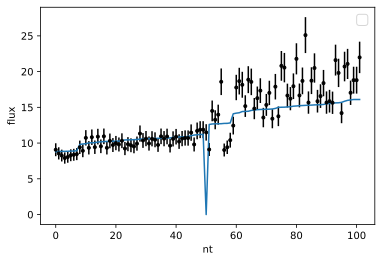

In [31]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

theta_fit = 2.978,283
labels = "eta","D"
stepi = eta_gss,D_gss
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print(f'eta = {eta_fit}\nD={D_fit}')
print('pv=',pv)
from IPython.display import display, Math
for i in range(2):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(theta_fit[i],stepi[i][0],stepi[i][1], labels[i])
    display(Math(txt))
print(Math(txt))

flux_fit = Model_neatm_ohhq(theta_fit,x,lamdai)
print(f'eta = {eta_fit}\nD={D_fit}')
print('pv=',pv)
print('loss= ',loss_func(y,1,flux_fit))
plt.plot(nt, flux_fit)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
plt.savefig('test.pdf',bbox_inches = 'tight')

/tmp/ipykernel_349523/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
No handles with labels found to put in legend.


570711568513.4287


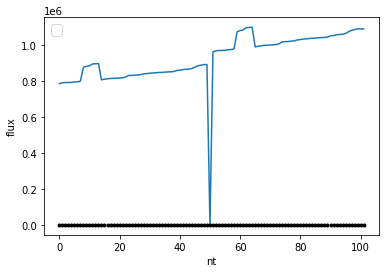

In [9]:
theta_fit = eta_fit,99000
flux_fit = Model_neatm_jhx(theta_fit,x,lamdai)
print(loss_func(y,yerr,flux_fit))
plt.plot(nt, flux_fit)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
